### Check if configuration has been run already and change directory to repository root:

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import os
import getpass
import pandas as pd
import subprocess
import json
import u19_pipeline.utils.path_utils as pu
import pathlib
import u19_pipeline.automatic_job as auto_pipeline
import u19_pipeline.automatic_job.recording_handler as rec_handler
import u19_pipeline.automatic_job.recording_process_handler as rec_process_handler


from u19_pipeline import recording, imaging_rec, ephys

#import utility.dj_shortcuts as dj_short
#import utility.acquisition_pipeline_handler as aph
dj.__version__

Connecting alvaros@datajoint00.pni.princeton.edu:3306


'0.13.2'

In [3]:
recording.StatusRecordingDefinition()

status_recording_idx status in the automate process pipeline,status_definition Status definition
-1,Error in recording handling
0,New recording
1,Recording directory transfer to PNI requested
2,Recording directory transferred to PNI
3,modality ingestion & Syncing jobs done


In [4]:
df_params = pd.DataFrame(recording.PreprocessParamSet.fetch(as_dict=True))
df_params

""


In [8]:

fake_recording = dict()
fake_recording['recording_modality'] = 'electrophysiology'
fake_recording['location'] = 'Bezos1'
fake_recording['status_recording_idx'] = 0
fake_recording['process_paramset_idx'] = 1
fake_recording['preprocess_paramset_idx'] = 3
fake_recording['recording_directory'] = 'ms81/ms81_M004/20210507/towersTask_g0'
fake_recording['local_directory'] = 'ms81/ms81_M004/20210507/towersTask_g0'

#recording.Recording.insert1(fake_recording, skip_duplicates=True)

In [5]:
fake_recording = dict()
fake_recording['recording_modality'] = 'imaging'
fake_recording['location'] = 'Bezos1'
fake_recording['status_recording_idx'] = 0
fake_recording['process_paramset_idx'] = 1
fake_recording['preprocess_paramset_idx'] = 3
fake_recording['recording_directory'] = 'emdia/emdia_gps24/20220111'
fake_recording['local_directory'] = 'emdia/emdia_gps24/20220111'

#recording.Recording.insert1(fake_recording, skip_duplicates=True)


In [9]:
l = rec_handler.RecordingHandler.pipeline_handler_main()

function to apply: modality_preingestion
['/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline_python/u19_pipeline/automatic_job/ingest_scaninfo_shell.sh', '/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline-matlab/scripts', 'recording_id=1']
aftercommand before comm
aftercommand after comm

                                                                              < M A T L A B (R) >
                                                                    Copyright 1984-2020 The MathWorks, Inc.
                                                                R2020b Update 1 (9.9.0.1495850) 64-bit (glnxa64)
                                                                               September 30, 2020

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
    ----------------------------------------------------
	Your license will expire in 14 days.
	Please contact your system administrator or
	MathWorks to renew this license.
    

KeyboardInterrupt: 

In [4]:
l = rec_handler.RecordingHandler.pipeline_handler_main()

In [3]:
l = rec_process_handler.RecProcessHandler.pipeline_handler_main()

suite2p
recording_process_id_16
<class 'str'>
<class 'numpy.str_'>
scp slurm_files/slurm_recording_process_id_16.slurm alvaros@tigergpu.princeton.edu:/scratch/gpfs/BRAINCOGS/slurm_files/slurm_recording_process_id_16.slurm
Permission denied (publickey,keyboard-interactive).
lost connection
update_dict {'value_update': None, 'error_info': None}
suite2p
recording_process_id_17
<class 'str'>
<class 'numpy.str_'>
scp slurm_files/slurm_recording_process_id_17.slurm alvaros@tigergpu.princeton.edu:/scratch/gpfs/BRAINCOGS/slurm_files/slurm_recording_process_id_17.slurm
Permission denied (publickey,keyboard-interactive).
lost connection
update_dict {'value_update': None, 'error_info': None}
suite2p
recording_process_id_18
<class 'str'>
<class 'numpy.str_'>
scp slurm_files/slurm_recording_process_id_18.slurm alvaros@tigergpu.princeton.edu:/scratch/gpfs/BRAINCOGS/slurm_files/slurm_recording_process_id_18.slurm
Permission denied (publickey,keyboard-interactive).
lost connection
update_dict {'value_

In [8]:
keyo = dict()
keyo['preprocess_paramset_idx'] = 1
a = recording.PreprocessParamSet()
lo = a.get_preprocess_params(keyo)

keyo2 = dict()
keyo2['process_paramset_idx'] = 1
b = recording.ProcessParamSet()
lu = b.get_process_params(keyo2)



[[(array([[2.]]), array(['kilosort2'], dtype='<U9'))]]
<class 'datajoint.blob.MatStruct'>
soy ndarray
soy ndarray


In [9]:
lo

{'cat_gt': 2, 'sorting_algorithm': 'kilosort2'}

In [21]:
diro = os.getcwd()
param_file = str(pathlib.Path(diro, 'u19_pipeline', 'automatic_job', 'process_params_examples', 'preprocess_params_example.json'))
f = open(param_file)
param_dict = json.load(f)
param_dict

keyu = dict()
keyu['preprocess_paramset_idx'] = 1
keyu['preprocess_paramset'] = param_dict
a.update1(keyu)

In [67]:
ws.columns

Index(['cat_gt', 'sorting_algorithm'], dtype='object')

In [6]:
recording.Recording()

recording_id Unique number assigned to each recording,"recording_modality modalities for recording (ephys, imaging, video_recording, etc.)",location,status_recording_idx status in the automate process pipeline,preprocess_paramset_idx,process_paramset_idx,task_copy_id_pni id for globus transfer task raw file local->cup,inherit_params_recording all RecordingProcess from a recording will have same paramSets,recording_directory relative directory where the recording will be stored on cup,local_directory local directory where the recording is stored on system
2,electrophysiology,Bezos1,3,1,1,None,1,ms81/ms81_M004/20210507/towersTask_g0,ms81/ms81_M004/20210507/towersTask_g0
3,electrophysiology,Bezos1,3,1,1,None,1,ms81/ms81_M004/20210507/towersTask_g0,ms81/ms81_M004/20210507/towersTask_g0
4,imaging,Bezos1,3,2,1,None,1,emdia/emdia_gps24/20220111,emdia/emdia_gps24/20220111


In [7]:
ephys.EphysRecordingProbes()

recording_id Unique number assigned to each recording,probe probe number for the recording,probe_directory probe specific directory
2,0,/Volumes/braininit/Data/electrophysiology/ms81/ms81_M004/20210507/towersTask_g0/towersTask_g0_imec0/
2,1,/Volumes/braininit/Data/electrophysiology/ms81/ms81_M004/20210507/towersTask_g0/towersTask_g0_imec1/
3,0,/Volumes/braininit/Data/electrophysiology/ms81/ms81_M004/20210507/towersTask_g0/towersTask_g0_imec0/
3,1,/Volumes/braininit/Data/electrophysiology/ms81/ms81_M004/20210507/towersTask_g0/towersTask_g0_imec1/


### Declare AutoPipeline and Status tables if they don't exist

In [8]:
ephys.EphysProcessing()

recording_process_id Unique number assigned to each processing job for a recording unit,recording_id Unique number assigned to each recording,probe probe number for the recording
16,2,0
17,2,1
18,3,0
19,3,1


In [9]:
imaging_rec.Scan()


recording_id Unique number assigned to each recording
4


In [10]:
imaging_rec.ScanInfo()

recording_id Unique number assigned to each recording,file_name_base base name of the file,scan_width width of scanning in pixels,scan_height height of scanning in pixels,acq_time acquisition time,n_depths number of depths,scan_depths depth values in this scan,frame_rate imaging frame rate,inter_fov_lag_sec time lag in secs between fovs,frame_ts_sec frame timestamps in secs 1xnFrames,channels is this the channer number or total number of channels,cfg_filename cfg file path,usr_filename usr file path,fast_z_lag fast z lag,fast_z_flyback_time time it takes to fly back to fov,line_period scan time per line,scan_frame_period,scan_volume_rate,flyback_time_per_frame,flyto_time_per_scan_field,"fov_corner_points coordinates of the corners of the full 5mm FOV, in microns",nfovs number of field of view,nframes number of frames in the scan,nframes_good number of frames in the scan before acceptable sample bleaching threshold is crossed,last_good_file number of the file containing the last good frame because of bleaching,motion_correction_enabled,motion_correction_mode,stacks_enabled,stack_actuator,stack_definition
4,emdia/emdia_gps24/20220111/gps24_20220111_mainrecording_00001_00001.tif,512,1588,2022-01-11 00:00:00,1,=BLOB=,14.3005,0.001,=BLOB=,=BLOB=,C:\Users\admin\Documents\MATLAB\MikaToo.cfg,C:\Users\admin\Documents\MATLAB\Mika.usr,0.0008,0.004,4.14754e-05,0.0699276,14.3005,0.001,0.001,=BLOB=,3,51468,36000,18,1,automated,1,fastZ,arbitrary


In [11]:
imaging_rec.ImagingProcessing()

recording_process_id Unique number assigned to each processing job for a recording unit,recording_id Unique number assigned to each recording,fov number of the field of view in this scan
27,4,1
28,4,2
29,4,3


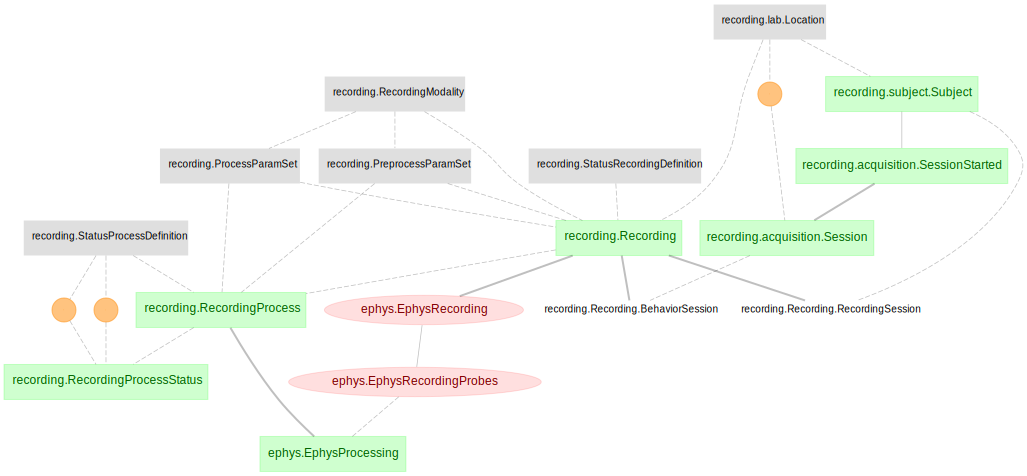

In [12]:
dj.ERD(recording) -1 + dj.ERD(ephys.EphysRecording) + dj.ERD(ephys.EphysProcessing)


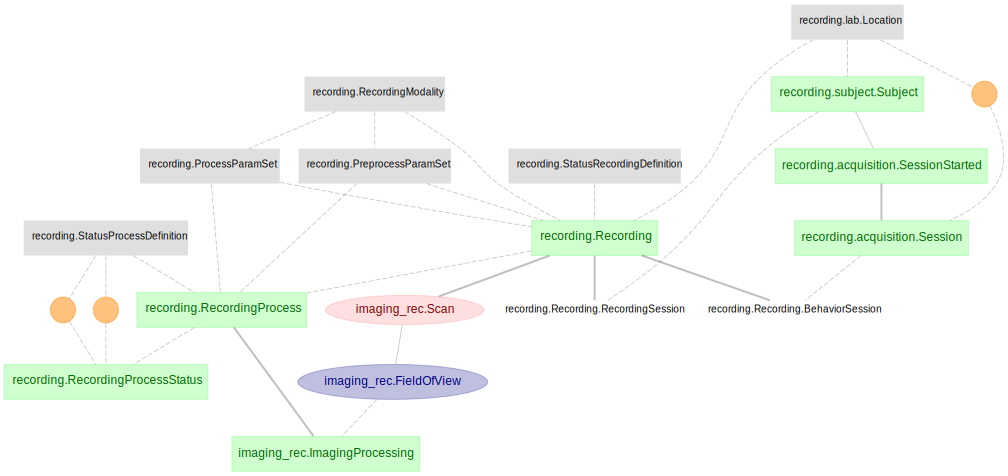

In [13]:
dj.ERD(recording) -1 + dj.ERD(imaging_rec.Scan) + dj.ERD(imaging_rec.ImagingProcessing) 


In [14]:
s =dj.conn()
s

DataJoint connection (connected) alvaros@datajoint00.pni.princeton.edu:3306

In [15]:
s.close()

In [89]:
dicto2 = [] 
dicto = dict()
dicto['wala'] = 1
dicto['walad'] = 2

dictos = dict()
dictos['wala'] = 3
dictos['walad'] = 4


dicto2.append(dicto)
dicto2.append(dictos)


In [90]:
str(dicto2)

"[{'wala': 1, 'walad': 2}, {'wala': 3, 'walad': 4}]"

In [81]:
l = [[k + '=' + str(v) for k,v in x.items()] for x in dicto2]
flat_list = ['('+' and '.join(sublist)+')' for sublist in l]
flat_list

['(wala=1 and walad=2)']

In [78]:
soo = ' or '.join(flat_list)
soo

'(wala=1 and walad=2)'

[['wala', 'walad'], ['wala', 'walad']]

In [91]:
def get_string_key(key):

    str_key = ''
    if isinstance(key, list):
        key_l = [[k + '=' + str(v) for k,v in x.items()] for x in key]
        flat_list = ['('+' and '.join(sublist)+')' for sublist in key_l]
        str_key = ' or '.join(flat_list)
    elif isinstance(key, dict):
        str_key = [k + '=' + str(v) for k,v in key.items()] 
    elif isinstance(key,str):
        str_key = key
    
    return str_key

In [92]:
get_string_key(dicto2)

'(wala=1 and walad=2) or (wala=3 and walad=4)'

In [4]:
so = imaging_rec.ScanInfo()

In [5]:
key = dict()
key['recording_id'] = 4

so.ingest(key)

['/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline_python/u19_pipeline/automatic_job/ingest_scaninfo_shell.sh', '/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline-matlab/scripts', 'recording_id=4']
aftercommand before comm
aftercommand after comm

                                                                              < M A T L A B (R) >
                                                                    Copyright 1984-2020 The MathWorks, Inc.
                                                                R2020b Update 1 (9.9.0.1495850) 64-bit (glnxa64)
                                                                               September 30, 2020

 
To get started, type doc.
For product information, visit www.mathworks.com.
 

s =

     0

 0:  datajoint00.pni.princeton.edu via TCP/IP   Server version 5.5.5-10.2.33-MariaDB (encrypted)
database connection id: 64946
imaging_rec.ScanInfo: Nothing to populate




In [3]:
imaging = dj.create_virtual_module('imaging', 'u19_imaging')

In [4]:
keyo = dict()
keyo['subject_fullname'] = 'emdia_teto6s_12'
keyo['session_date'] = '2021-11-12'


In [6]:
(imaging.Scan & keyo).delete()

Deleting 3 rows from `u19_imaging`.`__sync_imaging_behavior`
Deleting 87 rows from `u19_imaging`.`_field_of_view__file`


DataJointError: Cannot declare new tables inside a transaction, e.g. from inside a populate/make call

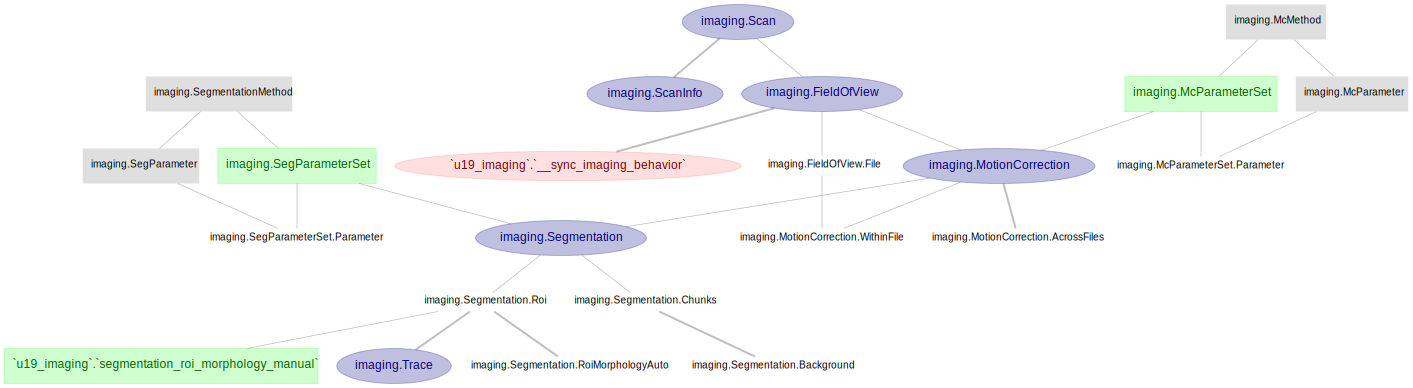

In [11]:
dj.Diagram(imaging)

In [10]:
import traceback
import sys
try:
    raise Exception('spam', 'eggs')
except BaseException as e:
    print('Nos salvamos')
    print(traceback.format_exc())


Nos salvamos
Traceback (most recent call last):
  File "/tmp/ipykernel_6488/1491040166.py", line 4, in <module>
    raise Exception('spam', 'eggs')
Exception: ('spam', 'eggs')

(<class 'Exception'>, Exception('spam', 'eggs'), <traceback object at 0x7f877dc35f00>)
